In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import torch
import torch.nn.functional as F
import torch_geometric as pyg
from torch_geometric.datasets import PPI
from model import GAT, SAGE
from adagrad import AdaGrad
from tabulate import tabulate
import os

### Download the Dataset

In [2]:
cwd = os.getcwd()
train_dataset = PPI(root=f'{cwd}/Datasets/PPI', split='train')
val_dataset = PPI(root=f'{cwd}', split='val')
test_dataset = PPI(root=f'{cwd}/Datasets/PPI', split='test')

### Insight into the dataset

In [3]:
def summarize_dataset(train_dataset, val_dataset, test_dataset):
    table = [["Train", len(train_dataset), train_dataset.num_node_features, train_dataset.num_classes],
             ["Val", len(val_dataset), val_dataset.num_node_features, val_dataset.num_classes],
             ["Test", len(test_dataset), test_dataset.num_node_features, test_dataset.num_classes]]
    
    print(tabulate(table, headers=["Split", "Number of Graphs", "Number of Features", "Number of Classes"]))

summarize_dataset(train_dataset, val_dataset, test_dataset)
print("\nSample Features:")
print(train_dataset[0].x[1])

print("\nSample Labels")
print(train_dataset[0].y[1])

Split      Number of Graphs    Number of Features    Number of Classes
-------  ------------------  --------------------  -------------------
Train                    20                    50                  121
Val                       2                    50                  121
Test                      2                    50                  121

Sample Features:
tensor([-0.0855, -0.0884, -0.1128, -0.1719, -0.0766, -0.1003, -0.0751, -0.1149,
        -0.1212, -0.0994,  0.0000, -0.1699, -0.0428, -0.1123, -0.0760, -0.1152,
        -0.1031, -0.1120, -0.1435, -0.0975, -0.0875, -0.1457, -0.1234, -0.1242,
        -0.0976, -0.1197, -0.1161, -0.0735, -0.0667, -0.0873, -0.1797, -0.1447,
        -0.1606, -0.1582, -0.1477, -0.4350, -0.1617, -0.1556, -0.1526, -0.1396,
        -0.1281, -0.1539, -0.1593, -0.1546, -0.1466, -0.1449, -0.1568, -0.1399,
        -0.1494, -0.1481])

Sample Labels
tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 1., 0., 1., 1

### Create a Dataloader

In [4]:
train_loader = pyg.loader.DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = pyg.loader.DataLoader(val_dataset, batch_size=2, shuffle=True)
test_loader = pyg.loader.DataLoader(test_dataset, batch_size=2, shuffle=True)

### Define your models

1. GAT Model with AdaGrad (written by me)
2. GAT Model with Adam

In [5]:
in_channels = train_dataset.num_node_features
hidden_channels = 256
out_channels = train_dataset.num_classes

In [6]:
# GAT Model with AdaGrad (written by me)
adagrad_model = SAGE(in_channels, hidden_channels, out_channels)
adagrad_optim = AdaGrad(adagrad_model.parameters(), lr=0.1)

print(pyg.nn.summary(adagrad_model, train_dataset[0].x, train_dataset[0].edge_index))

+-------------------+-------------------------+----------------+----------+
| Layer             | Input Shape             | Output Shape   | #Param   |
|-------------------+-------------------------+----------------+----------|
| SAGE              | [1767, 50], [2, 32318]  | [1767, 121]    | 188,281  |
| ├─(conv1)SAGEConv | [1767, 50], [2, 32318]  | [1767, 256]    | 25,856   |
| ├─(conv2)SAGEConv | [1767, 256], [2, 32318] | [1767, 256]    | 131,328  |
| ├─(linear)Linear  | [1767, 256]             | [1767, 121]    | 31,097   |
+-------------------+-------------------------+----------------+----------+


In [7]:
# GAT Model with Adam
adam_model = SAGE(in_channels, hidden_channels, out_channels)
adam_optim = torch.optim.Adam(adam_model.parameters(), lr=0.01)

print(pyg.nn.summary(adam_model, train_dataset[0].x, train_dataset[0].edge_index))

+-------------------+-------------------------+----------------+----------+
| Layer             | Input Shape             | Output Shape   | #Param   |
|-------------------+-------------------------+----------------+----------|
| SAGE              | [1767, 50], [2, 32318]  | [1767, 121]    | 188,281  |
| ├─(conv1)SAGEConv | [1767, 50], [2, 32318]  | [1767, 256]    | 25,856   |
| ├─(conv2)SAGEConv | [1767, 256], [2, 32318] | [1767, 256]    | 131,328  |
| ├─(linear)Linear  | [1767, 256]             | [1767, 121]    | 31,097   |
+-------------------+-------------------------+----------------+----------+


### Training, Evaluation and Testing Functions

In [8]:
def train(model, optim):
    model.train()
    train_loss = 0
    for data in train_loader:
        optim.zero_grad() 
        out = model(data.x, data.edge_index)  
        loss = torch.nn.functional.binary_cross_entropy_with_logits(out, data.y)  
        loss.backward() 
        optim.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    return train_loss

def eval(model):
    model.eval()
    val_loss = 0
    val_f1_score = 0
    with torch.no_grad():
        for data in val_loader:
            out = model(data.x, data.edge_index)
            loss = torch.nn.functional.binary_cross_entropy_with_logits(out, data.y)
            val_loss += loss.item()
            val_f1_score += calc_f1_score(out, data.y)

    val_loss /= len(val_loader)
    val_f1_score /= len(val_loader)

    return val_loss, val_f1_score

def test(model):
    model.eval()
    test_f1_score = 0
    with torch.no_grad():
        for data in test_loader:
            out = model(data.x, data.edge_index)
            test_f1_score += calc_f1_score(out, data.y)

    test_f1_score /= len(test_loader)
    return test_f1_score


def calc_f1_score(y_pred, y_true, threshold=0.5):
    y_pred = torch.where(y_pred > threshold, 1, 0).detach().numpy()
    y_true = y_true.detach().numpy()

    score = f1_score(y_true, y_pred, average='micro')

    return score

### Early Stopping Criteria

In [9]:
class EarlyStopping:
    def __init__(self, tolerance=10):
        self.tolerance = tolerance
        self.train_counter = 0
        self.prev_train_loss = float('inf')
        self.val_counter = 0
        self.prev_val_loss = float('inf')
        self.early_stop = False

    def check_train(self, train_loss):
        if (train_loss >= self.prev_train_loss):
            self.train_counter += 1
            if self.train_counter >= self.tolerance:
                self.early_stop = True
        else:
            self.train_counter = 0
            self.prev_train_loss = train_loss

    def check_val(self, val_loss):
        if (val_loss >= self.prev_val_loss):
            self.val_counter += 1
            if self.val_counter >= self.tolerance:
                self.early_stop = True
        else:
            self.val_counter = 0
            self.prev_val_loss = val_loss

### Generate Plots function

In [10]:
def line_plot(train, val, label):
    plt.figure(figsize=(8, 8))
    sns.lineplot(x=range(len(train)), y=train, label=f"Train {label}")
    sns.lineplot(x=range(len(val)), y=val, label=f"Val {label}")
    plt.xlabel("Epoch")
    plt.ylabel(label)
    plt.legend()
    plt.title(f"Train and Val {label}")
    plt.show()

def bar_plot(model1_acc, model2_acc, y_label, title):
    data = {
        'Model': ['SAGE_Adagrad', 'SAGE_Adam'],
        y_label : [model1_acc, model2_acc]
    }
    
    plt.figure(figsize=(8,6))
    sns.barplot(data=data, x='Model', y=y_label, palette='Blues')
    plt.title(title)
    plt.show()

### Begin Training

In [11]:
adagrad_train_losses = []
adagrad_val_losses = []
adagrad_val_f1_scores = []
early_stopping_1 = EarlyStopping()
for epoch in range(0, 50):
    train_loss = train(adagrad_model, adagrad_optim)
    adagrad_train_losses.append(train_loss)

    val_loss, val_f1_score = eval(adagrad_model)
    adagrad_val_losses.append(val_loss)
    adagrad_val_f1_scores.append(val_f1_score)

    early_stopping_1.check_train(train_loss)
    early_stopping_1.check_val(val_loss)
    if early_stopping_1.early_stop:
        print(f"Early Stopped at Iter: {epoch}")
        adagrad_iter = epoch
        break
    
    print(f'Epoch: {epoch:03d} -> Train Loss: {train_loss:.6f} Val Loss: {val_loss:.6f} Val F1 Score: {val_f1_score:.4f}')

Epoch: 000 -> Train Loss: 5.545696 Val Loss: 0.543565 Val F1 Score: 0.2996
Epoch: 001 -> Train Loss: 0.549022 Val Loss: 0.534990 Val F1 Score: 0.2987
Epoch: 002 -> Train Loss: 0.543712 Val Loss: 0.534469 Val F1 Score: 0.3060
Epoch: 003 -> Train Loss: 0.540341 Val Loss: 0.528791 Val F1 Score: 0.2982
Epoch: 004 -> Train Loss: 0.536054 Val Loss: 0.531214 Val F1 Score: 0.3076
Epoch: 005 -> Train Loss: 0.533600 Val Loss: 0.518318 Val F1 Score: 0.3081
Epoch: 006 -> Train Loss: 0.523085 Val Loss: 0.514903 Val F1 Score: 0.3328
Epoch: 007 -> Train Loss: 0.518657 Val Loss: 0.508597 Val F1 Score: 0.3262
Epoch: 008 -> Train Loss: 0.521920 Val Loss: 0.516855 Val F1 Score: 0.3837
Epoch: 009 -> Train Loss: 0.513319 Val Loss: 0.504965 Val F1 Score: 0.3762
Epoch: 010 -> Train Loss: 0.505347 Val Loss: 0.498674 Val F1 Score: 0.3774
Epoch: 011 -> Train Loss: 0.504294 Val Loss: 0.501453 Val F1 Score: 0.4218
Epoch: 012 -> Train Loss: 0.504136 Val Loss: 0.495005 Val F1 Score: 0.4248
Epoch: 013 -> Train Loss:

c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

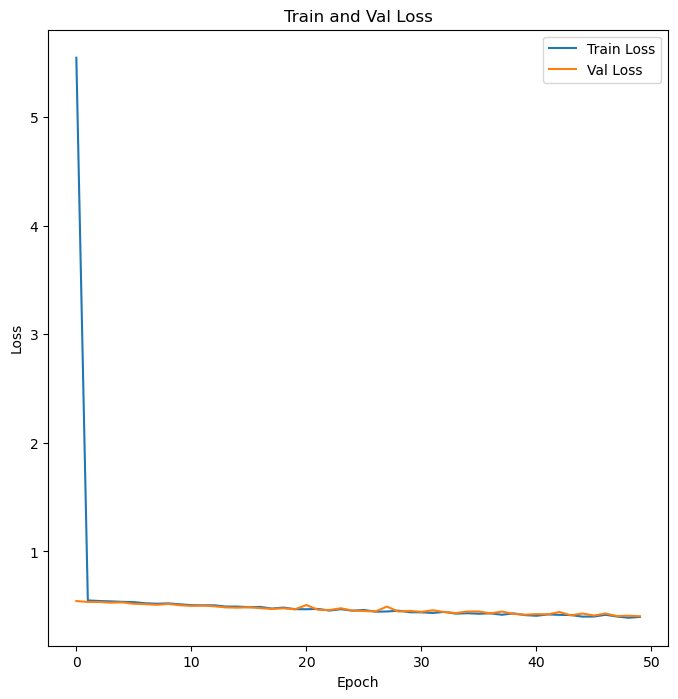

In [12]:
line_plot(adagrad_train_losses, adagrad_val_losses, 'Loss')

In [13]:
adam_train_losses = []
adam_val_losses = []
adam_val_f1_scores = []
early_stopping_2 = EarlyStopping()

for epoch in range(0, 50):
    train_loss = train(adam_model, adam_optim)
    adam_train_losses.append(train_loss)

    val_loss, val_f1_Score = eval(adam_model)
    adam_val_losses.append(val_loss)
    adam_val_f1_scores.append(val_f1_Score)

    early_stopping_2.check_train(train_loss)
    early_stopping_2.check_val(val_loss)
    if early_stopping_2.early_stop:
        print(f"Early Stopped at Iter: {epoch}")
        adagrad_iter = epoch
        break

    print(f'Epoch: {epoch:03d} -> Train Loss: {train_loss:.6f} Val Loss: {val_loss:.6f} Val F1 Score: {val_f1_Score:.4f}')

Epoch: 000 -> Train Loss: 0.584917 Val Loss: 0.539211 Val F1 Score: 0.3464
Epoch: 001 -> Train Loss: 0.544119 Val Loss: 0.523500 Val F1 Score: 0.2623
Epoch: 002 -> Train Loss: 0.521019 Val Loss: 0.499185 Val F1 Score: 0.3600
Epoch: 003 -> Train Loss: 0.490675 Val Loss: 0.473002 Val F1 Score: 0.4751
Epoch: 004 -> Train Loss: 0.460455 Val Loss: 0.450209 Val F1 Score: 0.4870
Epoch: 005 -> Train Loss: 0.443662 Val Loss: 0.445298 Val F1 Score: 0.4827
Epoch: 006 -> Train Loss: 0.429877 Val Loss: 0.430938 Val F1 Score: 0.5787
Epoch: 007 -> Train Loss: 0.408893 Val Loss: 0.413961 Val F1 Score: 0.5696
Epoch: 008 -> Train Loss: 0.394276 Val Loss: 0.406239 Val F1 Score: 0.5408
Epoch: 009 -> Train Loss: 0.383912 Val Loss: 0.392695 Val F1 Score: 0.5597
Epoch: 010 -> Train Loss: 0.369014 Val Loss: 0.383260 Val F1 Score: 0.6098
Epoch: 011 -> Train Loss: 0.357101 Val Loss: 0.375000 Val F1 Score: 0.6072
Epoch: 012 -> Train Loss: 0.353137 Val Loss: 0.370965 Val F1 Score: 0.6421
Epoch: 013 -> Train Loss:

c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

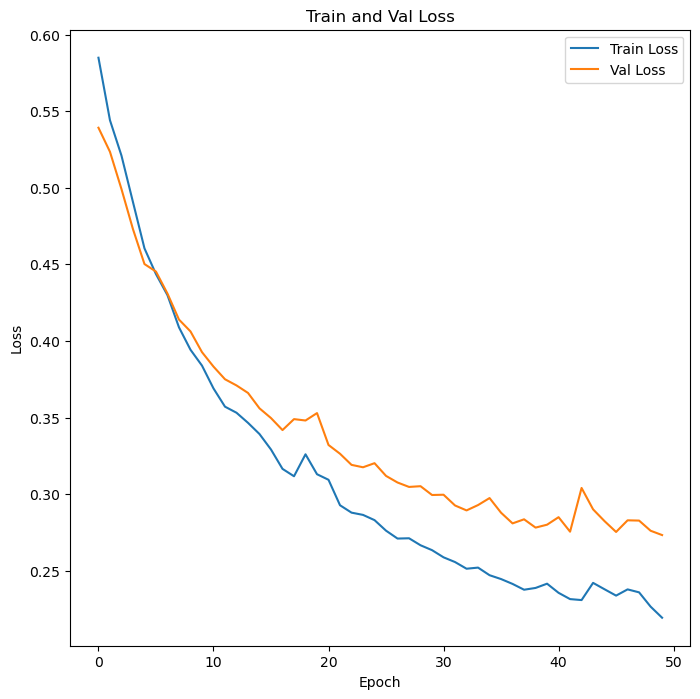

In [14]:
line_plot(adam_train_losses, adam_val_losses, 'Loss')

In [15]:
adagrad_test_f1_score = test(adagrad_model)
adam_test_f1_score = test(adam_model)

In [16]:
print(adagrad_test_f1_score)
print(adam_test_f1_score)

0.5272730467171495
0.7931517804167061


c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\vishh\.conda\envs\specpart_gnn\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, 

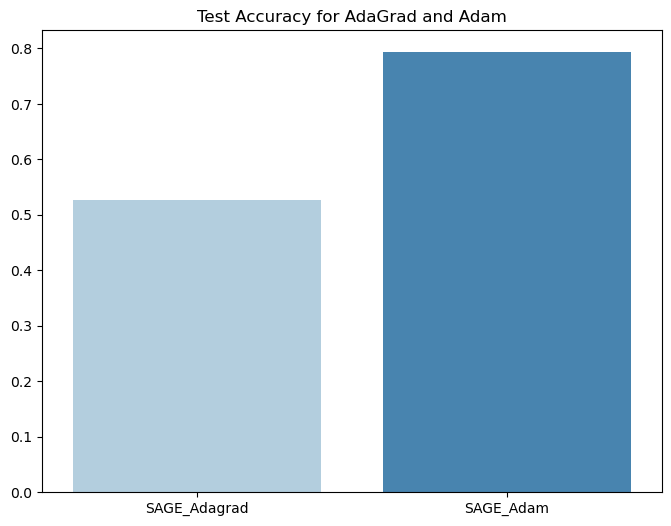

In [17]:
bar_plot(adagrad_test_f1_score, adam_test_f1_score, 'Accuracy', 'Test Accuracy for AdaGrad and Adam')